In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Dense , Dropout  , Flatten , GlobalAveragePooling2D , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.applications import VGG16 , MobileNetV2 , ResNet152 , EfficientNetB0
from tensorflow.keras.optimizers import Adam

In [1]:
# with zipfile.ZipFile("Retinal_OCT_Images.zip", 'r') as zip_ref:
#     for name in zip_ref.namelist():
#         print(repr(name))  

In [ ]:
zip_path = "Retinal_OCT_Images.zip"
extract_path = "./images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.namelist():

        fixed_path = member.replace("OCT2017 /", "OCT2017/").strip()


        target_path = os.path.join(extract_path, fixed_path)


        if member.endswith('/'):
            os.makedirs(target_path, exist_ok=True)
        else:
            os.makedirs(os.path.dirname(target_path), exist_ok=True)
            with open(target_path, 'wb') as f:
                f.write(zip_ref.read(member))

# print("Extracting complete")

Extracting complete


In [ ]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
test_generator = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
train = train_generator.flow_from_directory(
    "./images/OCT2017/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    )
test = test_generator.flow_from_directory(
    "./images/OCT2017/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False 
)
val = train_generator.flow_from_directory(
    "./images/OCT2017/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    )


Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [4]:
print(f"train images shape is {train.classes.shape}")
print(f"test images shape is {test.classes.shape}")
print(f"val images shape is {val.classes.shape}")

train images shape is (83484,)
test images shape is (968,)
val images shape is (32,)


In [5]:
print(f"unique values in the dataset: {np.unique(train.classes , return_counts=True)}")

unique values in the dataset: (array([0, 1, 2, 3]), array([37205, 11348,  8616, 26315], dtype=int64))


In [6]:
print(f"type of training data is {type(train)}")

type of training data is <class 'keras.src.preprocessing.image.DirectoryIterator'>


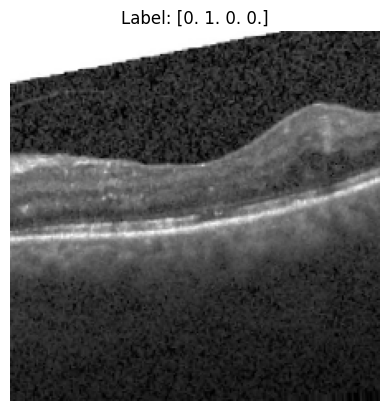

In [70]:
images_batch, labels_batch = train[0] 
image = images_batch[0]               
label = labels_batch[0]               

plt.imshow(image, cmap='gray')  
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


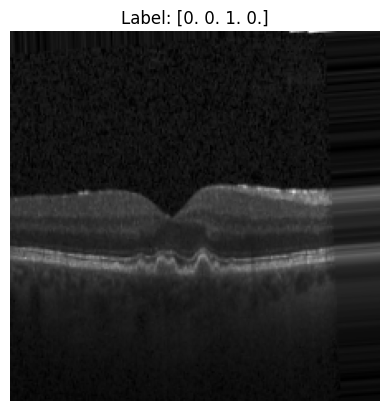

In [83]:
images_batch, labels_batch = train[1] 
image = images_batch[0]               
label = labels_batch[0]               

plt.imshow(image, cmap='gray')  
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [9]:
early_stop = EarlyStopping(monitor='val_loss' , patience=6 , mode='min' )
rlop = ReduceLROnPlateau(monitor='val_loss' , patience=4 , factor=0.5 , min_lr=1e-6)
check_point =  ModelCheckpoint('30_model.h5' , monitor='val_loss' , model='min' , save_best_only=True)

In [10]:
model_mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_mobilenet.trainable = False
model_mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train.classes),
    y=train.classes
)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.5609729875016799, 1: 1.8391787099048291, 2: 2.4223537604456826, 3: 0.7931217936538096}


In [12]:
model = Sequential()
model.add(model_mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

history = model.fit(train  , steps_per_epoch=250 , epochs=20, validation_data=test, callbacks=[early_stop , rlop , check_point] , class_weight=class_weights_dict)

Epoch 1/20
250/250 [==============================] - 116s 456ms/step - loss: 0.8925 - accuracy: 0.6769 - precision: 0.7550 - recall: 0.5785 - val_loss: 0.3696 - val_accuracy: 0.8667 - val_precision: 0.8926 - val_recall: 0.8326 - lr: 0.0010
Epoch 2/20


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 111s 445ms/step - loss: 0.7295 - accuracy: 0.7461 - precision: 0.7992 - recall: 0.6766 - val_loss: 0.3347 - val_accuracy: 0.8895 - val_precision: 0.9122 - val_recall: 0.8585 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 112s 447ms/step - loss: 0.6986 - accuracy: 0.7563 - precision: 0.8080 - recall: 0.6977 - val_loss: 0.3193 - val_accuracy: 0.9029 - val_precision: 0.9231 - val_recall: 0.8678 - lr: 0.0010
Epoch 4/20
250/250 [==============================] - 110s 440ms/step - loss: 0.6795 - accuracy: 0.7631 - precision: 0.8102 - recall: 0.7101 - val_loss: 0.3409 - val_accuracy: 0.8864 - val_precision: 0.9045 - val_recall: 0.8605 - lr: 0.0010
Epoch 5/20
250/250 [==============================] - 106s 423ms/step - loss: 0.6474 - accuracy: 0.7664 - precision: 0.8141 - recall: 0.7237 - val_loss: 0.3095 - val_accuracy: 0.8833 - val_precision: 0.9003 - val_recall: 0.8771 - lr: 0.0010
Epoch 6/20
250/250 [===========================

In [13]:
model = load_model("./30_model.h5")
model

In [14]:
results = model.evaluate(val)
print(f"Val Loss: {results[0]:.4f}")
print(f"Val Accuracy: {results[1] * 100:.2f}%")
print(f"Val Precision: {results[2] * 100:.2f}%")
print(f"Val Recall: {results[3] * 100:.2f}%")


1/1 [==============================] - 1s 1s/step - loss: 0.2004 - accuracy: 0.9688 - precision: 0.9677 - recall: 0.9375
Val Loss: 0.2004
Val Accuracy: 96.88%
Val Precision: 96.77%
Val Recall: 93.75%


In [15]:
results = model.evaluate(test)
print(f"test Loss: {results[0]:.4f}")
print(f"test Accuracy: {results[1] * 100:.2f}%")
print(f"test Precision: {results[2] * 100:.2f}%")
print(f"test Recall: {results[3] * 100:.2f}%")


31/31 [==============================] - 10s 314ms/step - loss: 0.2235 - accuracy: 0.9256 - precision: 0.9334 - recall: 0.9122
test Loss: 0.2235
test Accuracy: 92.56%
test Precision: 93.34%
test Recall: 91.22%


31/31 [==============================] - 10s 310ms/step
              precision    recall  f1-score   support

         CNV       0.95      0.90      0.92       242
         DME       0.93      0.92      0.93       242
      DRUSEN       0.89      0.91      0.90       242
      NORMAL       0.93      0.97      0.95       242

    accuracy                           0.93       968
   macro avg       0.93      0.93      0.93       968
weighted avg       0.93      0.93      0.93       968



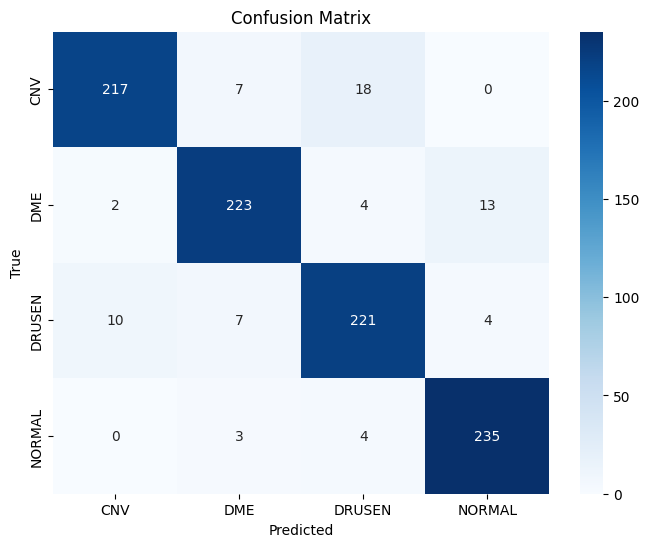

In [ ]:
steps = test.samples // test.batch_size + int(test.samples % test.batch_size != 0)


y_pred = model.predict(test, steps=steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test.classes
class_names = list(test.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


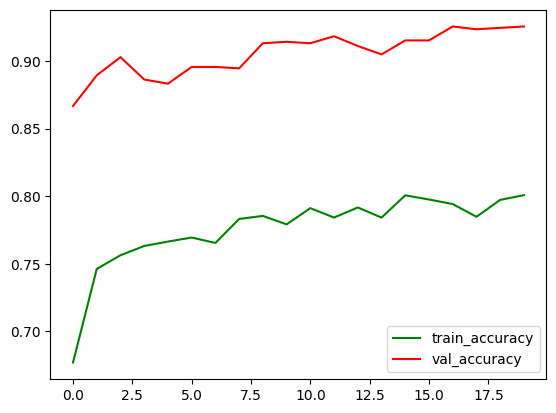

In [17]:
plt.plot(history.history['accuracy'] , color="green" , label="train_accuracy")
plt.plot(history.history['val_accuracy'] , color="red" , label="val_accuracy")
plt.legend()
plt.show()

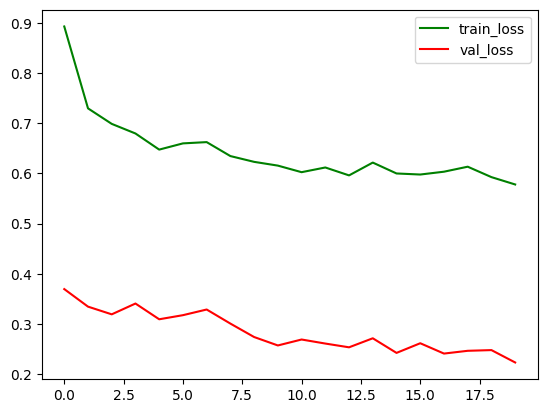

In [18]:
plt.plot(history.history['loss'] , color="green" , label="train_loss")
plt.plot(history.history['val_loss'] , color="red" , label="val_loss")
plt.legend()
plt.show()

In [ ]:
class_names = list(test.class_indices.keys())
class_names

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
img_size = (224, 224)
batch_size = 32
epochs_initial = 5
epochs_finetune = 3
num_classes = 4
base_model = load_model("./30_model.h5")

base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# callbacks
early = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.2)
check_point =  ModelCheckpoint('finetune_30_model.h5' , monitor='val_loss' , model='min' , save_best_only=True)


model.fit(train, epochs=epochs_finetune, validation_data=test, callbacks=[early, reduce_lr , check_point] , class_weight=class_weights_dict , steps_per_epoch=250)

Epoch 1/3
250/250 [==============================] - 111s 435ms/step - loss: 0.5578 - accuracy: 0.8064 - precision: 0.8411 - recall: 0.7690 - val_loss: 0.2225 - val_accuracy: 0.9246 - val_precision: 0.9335 - val_recall: 0.9132 - lr: 1.0000e-05
Epoch 2/3


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 107s 429ms/step - loss: 0.5551 - accuracy: 0.8041 - precision: 0.8395 - recall: 0.7694 - val_loss: 0.2240 - val_accuracy: 0.9236 - val_precision: 0.9322 - val_recall: 0.9091 - lr: 1.0000e-05
Epoch 3/3
250/250 [==============================] - 114s 457ms/step - loss: 0.5395 - accuracy: 0.8111 - precision: 0.8430 - recall: 0.7745 - val_loss: 0.2242 - val_accuracy: 0.9236 - val_precision: 0.9333 - val_recall: 0.9112 - lr: 1.0000e-05


31/31 [==============================] - 11s 335ms/step


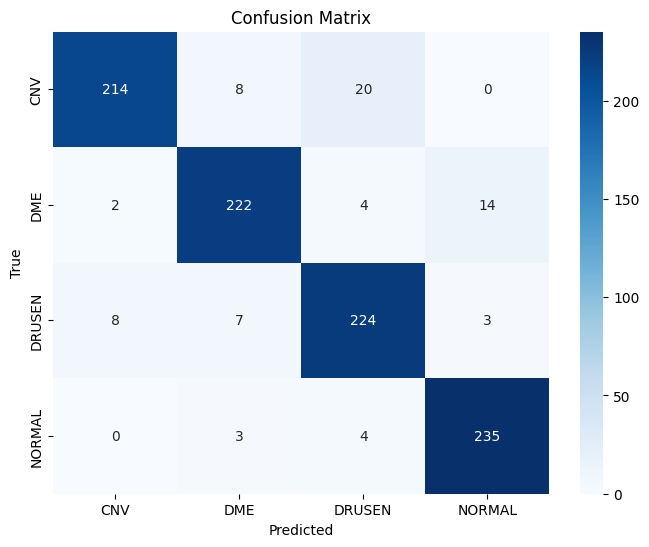

Classification Report:
              precision    recall  f1-score   support

         CNV       0.96      0.88      0.92       242
         DME       0.93      0.92      0.92       242
      DRUSEN       0.89      0.93      0.91       242
      NORMAL       0.93      0.97      0.95       242

    accuracy                           0.92       968
   macro avg       0.93      0.92      0.92       968
weighted avg       0.93      0.92      0.92       968



In [21]:
model = load_model("./finetune_30_model.h5")

pred = model.predict(test)
pred_labels = np.argmax(pred, axis=1)
true_labels = test.classes
class_names = list(test.class_indices.keys())

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

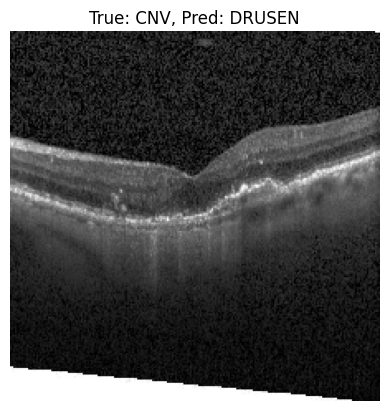

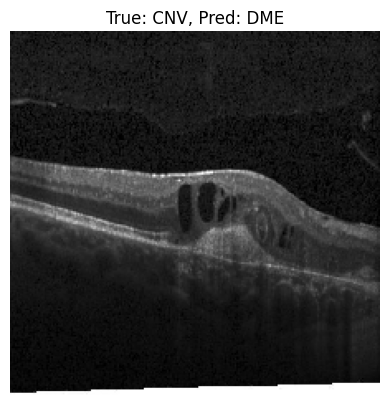

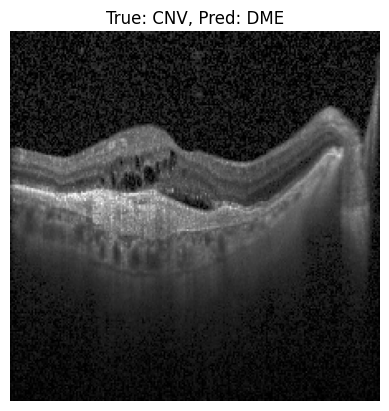

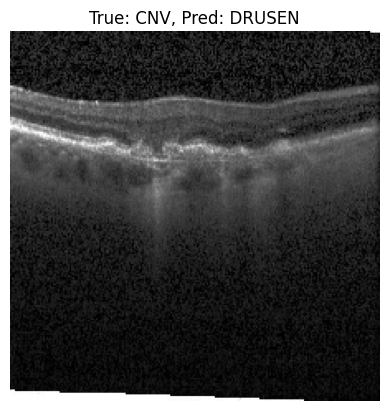

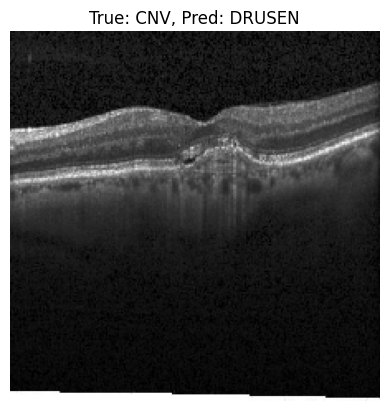

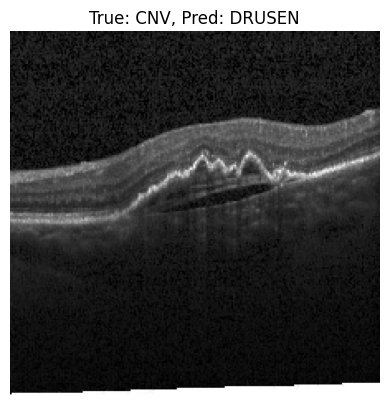

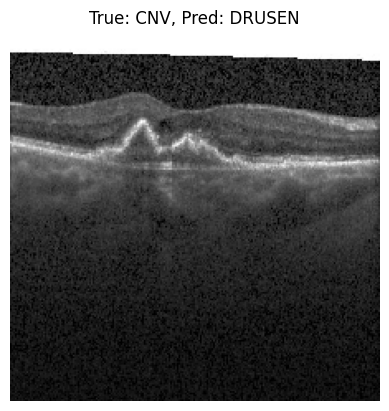

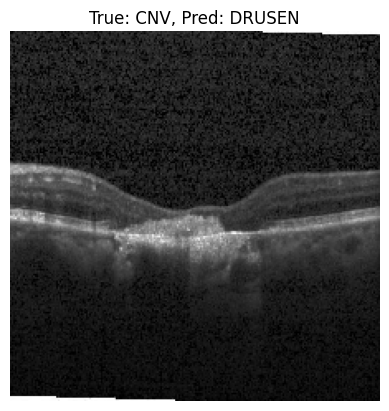

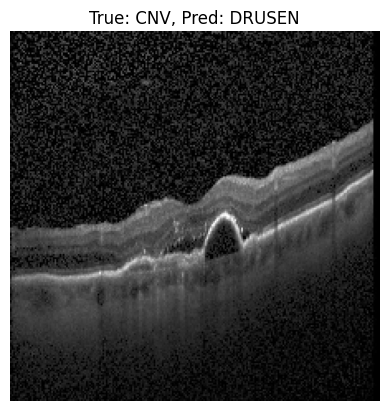

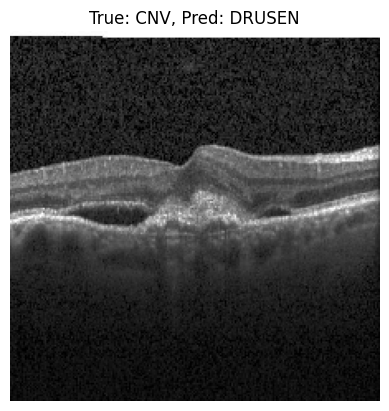

In [ ]:
wrong_idx = np.where(y_pred_classes != y_true)[0]


for i in range(10):
    idx = wrong_idx[i]

    batch_idx = idx // test.batch_size
    image_idx = idx % test.batch_size

    batch = test[batch_idx]  
    img = batch[0][image_idx]  
    true_label = y_true[idx]
    pred_label = y_pred_classes[idx]

    plt.imshow(img)
    plt.title(f"True: {class_names[true_label]}, Pred: {class_names[pred_label]}")
    plt.axis('off')
    plt.show()
